In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "uni90"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 326
Categorical features: 10
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 398
Categorical Columns: 10


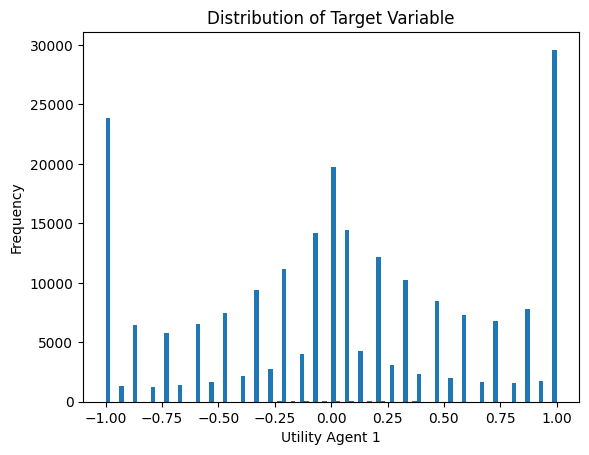

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55415


[100]	val-rmse:0.46853


[200]	val-rmse:0.45266


[300]	val-rmse:0.44474


[400]	val-rmse:0.43856


[500]	val-rmse:0.43505


[600]	val-rmse:0.43252


[700]	val-rmse:0.43112


[800]	val-rmse:0.43033


[900]	val-rmse:0.42966


[1000]	val-rmse:0.42919


[1100]	val-rmse:0.42872


[1200]	val-rmse:0.42841


[1300]	val-rmse:0.42802


[1400]	val-rmse:0.42803


[1500]	val-rmse:0.42776


[1600]	val-rmse:0.42769


[1700]	val-rmse:0.42789


[1800]	val-rmse:0.42794


[1900]	val-rmse:0.42796


[2000]	val-rmse:0.42798


[2100]	val-rmse:0.42797


[2200]	val-rmse:0.42799


[2300]	val-rmse:0.42804


[2400]	val-rmse:0.42804


[2499]	val-rmse:0.42813


Fold 1 - RMSE: 0.4278370035849392
Fold 2


[0]	val-rmse:0.58865


[100]	val-rmse:0.48429


[200]	val-rmse:0.47051


[300]	val-rmse:0.46557


[400]	val-rmse:0.46125


[500]	val-rmse:0.45858


[600]	val-rmse:0.45670


[700]	val-rmse:0.45539


[800]	val-rmse:0.45451


[900]	val-rmse:0.45350


[1000]	val-rmse:0.45291


[1100]	val-rmse:0.45275


[1200]	val-rmse:0.45243


[1300]	val-rmse:0.45200


[1400]	val-rmse:0.45187


[1500]	val-rmse:0.45149


[1600]	val-rmse:0.45132


[1700]	val-rmse:0.45133


[1800]	val-rmse:0.45117


[1900]	val-rmse:0.45107


[2000]	val-rmse:0.45111


[2100]	val-rmse:0.45114


[2200]	val-rmse:0.45107


[2300]	val-rmse:0.45102


[2400]	val-rmse:0.45103


[2499]	val-rmse:0.45099


Fold 2 - RMSE: 0.45028742000270894
Fold 3


[0]	val-rmse:0.60506


[100]	val-rmse:0.47885


[200]	val-rmse:0.45968


[300]	val-rmse:0.45234


[400]	val-rmse:0.44782


[500]	val-rmse:0.44515


[600]	val-rmse:0.44373


[700]	val-rmse:0.44253


[800]	val-rmse:0.44174


[900]	val-rmse:0.44086


[1000]	val-rmse:0.44045


[1100]	val-rmse:0.44019


[1200]	val-rmse:0.44010


[1300]	val-rmse:0.43996


[1400]	val-rmse:0.43989


[1500]	val-rmse:0.43965


[1600]	val-rmse:0.43946


[1700]	val-rmse:0.43930


[1800]	val-rmse:0.43926


[1900]	val-rmse:0.43915


[2000]	val-rmse:0.43913


[2100]	val-rmse:0.43906


[2200]	val-rmse:0.43894


[2300]	val-rmse:0.43878


[2400]	val-rmse:0.43873


[2499]	val-rmse:0.43861


Fold 3 - RMSE: 0.4381785970399111
Fold 4


[0]	val-rmse:0.59628


[100]	val-rmse:0.48235


[200]	val-rmse:0.46380


[300]	val-rmse:0.45561


[400]	val-rmse:0.45013


[500]	val-rmse:0.44749


[600]	val-rmse:0.44537


[700]	val-rmse:0.44425


[800]	val-rmse:0.44354


[900]	val-rmse:0.44267


[1000]	val-rmse:0.44209


[1100]	val-rmse:0.44180


[1200]	val-rmse:0.44144


[1300]	val-rmse:0.44101


[1400]	val-rmse:0.44069


[1500]	val-rmse:0.44070


[1600]	val-rmse:0.44046


[1700]	val-rmse:0.44031


[1800]	val-rmse:0.44009


[1900]	val-rmse:0.44012


[2000]	val-rmse:0.43996


[2100]	val-rmse:0.43990


[2200]	val-rmse:0.43985


[2300]	val-rmse:0.43988


[2400]	val-rmse:0.43987


[2499]	val-rmse:0.43976


Fold 4 - RMSE: 0.43930638533046695
Fold 5


[0]	val-rmse:0.54847


[100]	val-rmse:0.45551


[200]	val-rmse:0.43831


[300]	val-rmse:0.42952


[400]	val-rmse:0.42273


[500]	val-rmse:0.41936


[600]	val-rmse:0.41715


[700]	val-rmse:0.41562


[800]	val-rmse:0.41394


[900]	val-rmse:0.41306


[1000]	val-rmse:0.41243


[1100]	val-rmse:0.41197


[1200]	val-rmse:0.41159


[1300]	val-rmse:0.41122


[1400]	val-rmse:0.41107


[1500]	val-rmse:0.41082


[1600]	val-rmse:0.41072


[1700]	val-rmse:0.41074


[1800]	val-rmse:0.41070


[1900]	val-rmse:0.41072


[2000]	val-rmse:0.41072


[2100]	val-rmse:0.41078


[2200]	val-rmse:0.41081


[2300]	val-rmse:0.41086


[2400]	val-rmse:0.41072


[2499]	val-rmse:0.41075


Fold 5 - RMSE: 0.41046169186216647
List of oof scores: [0.4278370035849392, 0.45028742000270894, 0.4381785970399111, 0.43930638533046695, 0.41046169186216647]
Average oof score: 0.4332142195640385


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53648


[100]	val-rmse:0.44971


[200]	val-rmse:0.43453


[300]	val-rmse:0.42690


[400]	val-rmse:0.42227


[500]	val-rmse:0.41918


[600]	val-rmse:0.41689


[700]	val-rmse:0.41530


[800]	val-rmse:0.41391


[900]	val-rmse:0.41307


[1000]	val-rmse:0.41231


[1100]	val-rmse:0.41188


[1200]	val-rmse:0.41145


[1300]	val-rmse:0.41116


[1400]	val-rmse:0.41080


[1500]	val-rmse:0.41063


[1600]	val-rmse:0.41049


[1700]	val-rmse:0.41029


[1800]	val-rmse:0.41021


[1900]	val-rmse:0.41006


[2000]	val-rmse:0.40983


[2100]	val-rmse:0.40968


[2200]	val-rmse:0.40964


[2300]	val-rmse:0.40958


[2400]	val-rmse:0.40945


[2499]	val-rmse:0.40946


Fold 1 - RMSE: 0.40925812100047043
Fold 2


[0]	val-rmse:0.54582


[100]	val-rmse:0.43398


[200]	val-rmse:0.41729


[300]	val-rmse:0.41199


[400]	val-rmse:0.40844


[500]	val-rmse:0.40677


[600]	val-rmse:0.40567


[700]	val-rmse:0.40501


[800]	val-rmse:0.40432


[900]	val-rmse:0.40384


[1000]	val-rmse:0.40346


[1100]	val-rmse:0.40325


[1200]	val-rmse:0.40323


[1300]	val-rmse:0.40326


[1400]	val-rmse:0.40336


[1500]	val-rmse:0.40325


[1600]	val-rmse:0.40348


[1700]	val-rmse:0.40348


[1800]	val-rmse:0.40351


[1900]	val-rmse:0.40363


[2000]	val-rmse:0.40355


[2100]	val-rmse:0.40363


[2200]	val-rmse:0.40374


[2300]	val-rmse:0.40390


[2400]	val-rmse:0.40408


[2499]	val-rmse:0.40416


Fold 2 - RMSE: 0.40335847110361933
Fold 3


[0]	val-rmse:0.61293


[100]	val-rmse:0.48911


[200]	val-rmse:0.46816


[300]	val-rmse:0.45788


[400]	val-rmse:0.45123


[500]	val-rmse:0.44712


[600]	val-rmse:0.44498


[700]	val-rmse:0.44334


[800]	val-rmse:0.44185


[900]	val-rmse:0.44092


[1000]	val-rmse:0.44016


[1100]	val-rmse:0.43973


[1200]	val-rmse:0.43912


[1300]	val-rmse:0.43857


[1400]	val-rmse:0.43829


[1500]	val-rmse:0.43793


[1600]	val-rmse:0.43754


[1700]	val-rmse:0.43747


[1800]	val-rmse:0.43726


[1900]	val-rmse:0.43704


[2000]	val-rmse:0.43693


[2100]	val-rmse:0.43669


[2200]	val-rmse:0.43661


[2300]	val-rmse:0.43652


[2400]	val-rmse:0.43660


[2499]	val-rmse:0.43658


Fold 3 - RMSE: 0.43623228561661975
Fold 4


[0]	val-rmse:0.60519


[100]	val-rmse:0.49092


[200]	val-rmse:0.46776


[300]	val-rmse:0.45893


[400]	val-rmse:0.45369


[500]	val-rmse:0.45086


[600]	val-rmse:0.44919


[700]	val-rmse:0.44812


[800]	val-rmse:0.44713


[900]	val-rmse:0.44637


[1000]	val-rmse:0.44613


[1100]	val-rmse:0.44565


[1200]	val-rmse:0.44540


[1300]	val-rmse:0.44516


[1400]	val-rmse:0.44489


[1500]	val-rmse:0.44479


[1600]	val-rmse:0.44462


[1700]	val-rmse:0.44467


[1800]	val-rmse:0.44456


[1900]	val-rmse:0.44450


[2000]	val-rmse:0.44457


[2100]	val-rmse:0.44446


[2200]	val-rmse:0.44434


[2300]	val-rmse:0.44429


[2400]	val-rmse:0.44429


[2499]	val-rmse:0.44422


Fold 4 - RMSE: 0.4438806520979972
Fold 5


[0]	val-rmse:0.59028


[100]	val-rmse:0.48103


[200]	val-rmse:0.46099


[300]	val-rmse:0.45195


[400]	val-rmse:0.44533


[500]	val-rmse:0.44179


[600]	val-rmse:0.43984


[700]	val-rmse:0.43847


[800]	val-rmse:0.43733


[900]	val-rmse:0.43630


[1000]	val-rmse:0.43570


[1100]	val-rmse:0.43513


[1200]	val-rmse:0.43495


[1300]	val-rmse:0.43467


[1400]	val-rmse:0.43437


[1500]	val-rmse:0.43410


[1600]	val-rmse:0.43398


[1700]	val-rmse:0.43392


[1800]	val-rmse:0.43381


[1900]	val-rmse:0.43371


[2000]	val-rmse:0.43378


[2100]	val-rmse:0.43381


[2200]	val-rmse:0.43375


[2300]	val-rmse:0.43378


[2400]	val-rmse:0.43364


[2499]	val-rmse:0.43369


Fold 5 - RMSE: 0.4331838070211579
List of oof scores: [0.40925812100047043, 0.40335847110361933, 0.43623228561661975, 0.4438806520979972, 0.4331838070211579]
Average oof score: 0.42518266736797294


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57506


[100]	val-rmse:0.47849


[200]	val-rmse:0.46134


[300]	val-rmse:0.45355


[400]	val-rmse:0.44784


[500]	val-rmse:0.44489


[600]	val-rmse:0.44303


[700]	val-rmse:0.44200


[800]	val-rmse:0.44131


[900]	val-rmse:0.44040


[1000]	val-rmse:0.43989


[1100]	val-rmse:0.43962


[1200]	val-rmse:0.43941


[1300]	val-rmse:0.43914


[1400]	val-rmse:0.43901


[1500]	val-rmse:0.43890


[1600]	val-rmse:0.43881


[1700]	val-rmse:0.43888


[1800]	val-rmse:0.43876


[1900]	val-rmse:0.43867


[2000]	val-rmse:0.43857


[2100]	val-rmse:0.43865


[2200]	val-rmse:0.43867


[2300]	val-rmse:0.43871


[2400]	val-rmse:0.43860


[2499]	val-rmse:0.43872


Fold 1 - RMSE: 0.43831658565440856
Fold 2


[0]	val-rmse:0.57455


[100]	val-rmse:0.46890


[200]	val-rmse:0.44774


[300]	val-rmse:0.43841


[400]	val-rmse:0.43141


[500]	val-rmse:0.42756


[600]	val-rmse:0.42469


[700]	val-rmse:0.42293


[800]	val-rmse:0.42151


[900]	val-rmse:0.42055


[1000]	val-rmse:0.42000


[1100]	val-rmse:0.41936


[1200]	val-rmse:0.41859


[1300]	val-rmse:0.41813


[1400]	val-rmse:0.41785


[1500]	val-rmse:0.41783


[1600]	val-rmse:0.41766


[1700]	val-rmse:0.41755


[1800]	val-rmse:0.41752


[1900]	val-rmse:0.41738


[2000]	val-rmse:0.41737


[2100]	val-rmse:0.41713


[2200]	val-rmse:0.41710


[2300]	val-rmse:0.41708


[2400]	val-rmse:0.41716


[2499]	val-rmse:0.41723


Fold 2 - RMSE: 0.4169681348818479
Fold 3


[0]	val-rmse:0.57778


[100]	val-rmse:0.47299


[200]	val-rmse:0.45638


[300]	val-rmse:0.45039


[400]	val-rmse:0.44652


[500]	val-rmse:0.44378


[600]	val-rmse:0.44258


[700]	val-rmse:0.44166


[800]	val-rmse:0.44124


[900]	val-rmse:0.44048


[1000]	val-rmse:0.43998


[1100]	val-rmse:0.43971


[1200]	val-rmse:0.43958


[1300]	val-rmse:0.43927


[1400]	val-rmse:0.43904


[1500]	val-rmse:0.43881


[1600]	val-rmse:0.43873


[1700]	val-rmse:0.43862


[1800]	val-rmse:0.43851


[1900]	val-rmse:0.43846


[2000]	val-rmse:0.43845


[2100]	val-rmse:0.43849


[2200]	val-rmse:0.43840


[2300]	val-rmse:0.43832


[2400]	val-rmse:0.43815


[2499]	val-rmse:0.43815


Fold 3 - RMSE: 0.4378746101120322
Fold 4


[0]	val-rmse:0.57522


[100]	val-rmse:0.46260


[200]	val-rmse:0.44408


[300]	val-rmse:0.43778


[400]	val-rmse:0.43243


[500]	val-rmse:0.42873


[600]	val-rmse:0.42680


[700]	val-rmse:0.42535


[800]	val-rmse:0.42426


[900]	val-rmse:0.42319


[1000]	val-rmse:0.42264


[1100]	val-rmse:0.42234


[1200]	val-rmse:0.42217


[1300]	val-rmse:0.42177


[1400]	val-rmse:0.42154


[1500]	val-rmse:0.42146


[1600]	val-rmse:0.42149


[1700]	val-rmse:0.42141


[1800]	val-rmse:0.42128


[1900]	val-rmse:0.42122


[2000]	val-rmse:0.42116


[2100]	val-rmse:0.42103


[2200]	val-rmse:0.42104


[2300]	val-rmse:0.42100


[2400]	val-rmse:0.42095


[2499]	val-rmse:0.42095


Fold 4 - RMSE: 0.42062024652903063
Fold 5


[0]	val-rmse:0.58600


[100]	val-rmse:0.47882


[200]	val-rmse:0.45954


[300]	val-rmse:0.45010


[400]	val-rmse:0.44371


[500]	val-rmse:0.43916


[600]	val-rmse:0.43681


[700]	val-rmse:0.43523


[800]	val-rmse:0.43389


[900]	val-rmse:0.43299


[1000]	val-rmse:0.43250


[1100]	val-rmse:0.43193


[1200]	val-rmse:0.43153


[1300]	val-rmse:0.43125


[1400]	val-rmse:0.43102


[1500]	val-rmse:0.43105


[1600]	val-rmse:0.43101


[1700]	val-rmse:0.43099


[1800]	val-rmse:0.43086


[1900]	val-rmse:0.43068


[2000]	val-rmse:0.43062


[2100]	val-rmse:0.43053


[2200]	val-rmse:0.43043


[2300]	val-rmse:0.43053


[2400]	val-rmse:0.43051


[2499]	val-rmse:0.43048


Fold 5 - RMSE: 0.4301594789969221
List of oof scores: [0.43831658565440856, 0.4169681348818479, 0.4378746101120322, 0.42062024652903063, 0.4301594789969221]
Average oof score: 0.4287878112348483


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4278
Score: 0.4503
Score: 0.4382
Score: 0.4393
Score: 0.4105
Average CV1 Score: 0.4332

CV2 OOF Scores:
Score: 0.4093
Score: 0.4034
Score: 0.4362
Score: 0.4439
Score: 0.4332
Average CV2 Score: 0.4252

CV3 OOF Scores:
Score: 0.4383
Score: 0.4170
Score: 0.4379
Score: 0.4206
Score: 0.4302
Average CV3 Score: 0.4288


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

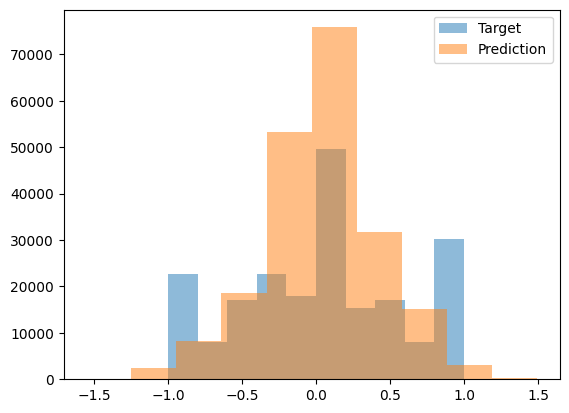

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***